# Microscope Project Main Code

In [1]:
# Import relevant libraries.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy import ndimage

from pandas import DataFrame         # to build our table of data from the video.
import pims                          # to import the video.
import scipy.ndimage as nd           # for Gaussian filter.
from skimage import filters

import trackpy as tp                 # for object tracking functions.

mpl.rcParams['image.cmap'] = 'gray'  # to set our default colourmap as grey.

In [2]:
# Import the video into the variable 'frames'.
# Change 'path' to directory of images



frames_full_video = pims.Video( '/Volumes/Stan_16GB/Week_3/Primo Star (2nd)/Immotile_primo_w3.m4v' )


A non-intra slice in an IDR NAL unit.
decode_slice_header error
A non-intra slice in an IDR NAL unit.
decode_slice_header error


In [3]:
# Check the properties of frames_full_video to get total number and shape.

print( frames_full_video ) # Also see how many fps as this will affect the crop

<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: /Volumes/Stan_16GB/Week_3/Primo Star (2nd)/Immotile_primo_w3.m4v
Duration: 24.667 seconds
Frame rate: 24.000 fps
Length: 591 frames
Frame Shape: (1080, 1920, 3)



In [4]:
frames = frames_full_video[60:420] # 15 seconds so that the computer can process better (24fps)
frames_full_video = 0

In [5]:
# Check the properties of frames to get total number and shape.

print( frames )

Sliced PyAVReaderTimed. Original repr:
    <Frames>
    Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
    Source: /Volumes/Stan_16GB/Week_3/Primo Star (2nd)/Immotile_primo_w3.m4v
    Duration: 24.667 seconds
    Frame rate: 24.000 fps
    Length: 591 frames
    Frame Shape: (1080, 1920, 3)
    


A non-intra slice in an IDR NAL unit.
decode_slice_header error


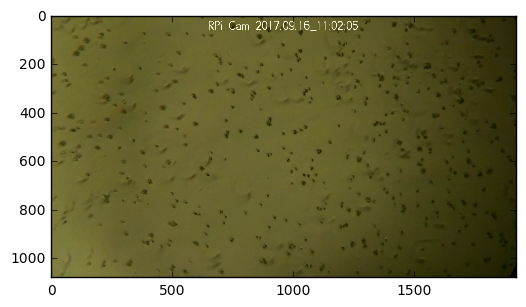

In [6]:
plt.imshow(frames[0])

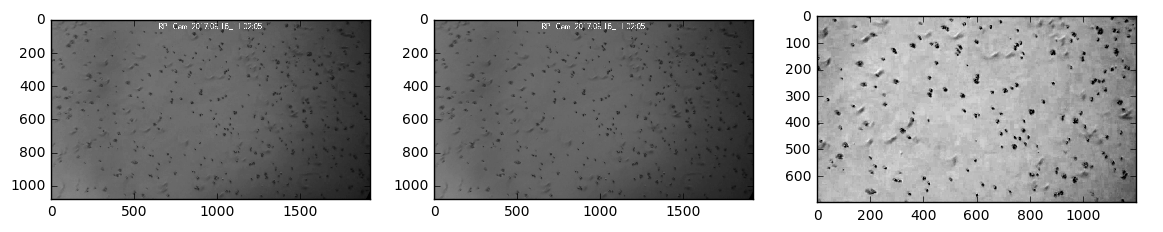

In [7]:
# Plot the red, green and blue channels of the first frame

fig, ax = plt.subplots( nrows = 1, ncols = 3, figsize = (14, 5) )

ax[0].imshow( frames[0][:,:,0] )
ax[1].imshow( frames[0][:,:,1] )
ax[2].imshow( frames[0][200:900,300:1500,2] )

## Preparing the data
First, we need to crop the image and choose a colour channel to work with. This makes downstream processing much faster and removes shadowed areas of the image. Like the week 5 example, you may need to change the area you are looking at as the 'slice' values are currently set to the example video.
## Once you have settled on a crop you need to keep these settings for all repeats and strains.
Remember the format of the slice is Y1 Y2 X1 X2, where '1' is the top left corner and '2' is the bottom right corner.

In [8]:
# As in the previous notebook, let's define a crop and choose the red channel to work with

crop = (slice(200, 900), slice(300, 1500), 2)
# frames_crop = [frame[200:900,300:1500,2] for frame in frames]
frames_crop = np.array( [frame[crop] for frame in frames], dtype=float )
frames = 0

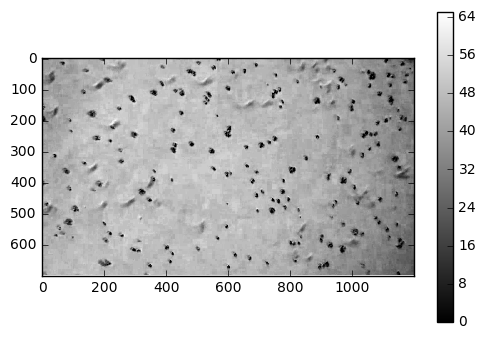

In [9]:
# Plot a frame of the cropped image to check progress.
# You need to make sure you have an even level of brightness across the background.

plt.figure()

plt.imshow(frames_crop[0] )
plt.colorbar()

In [10]:
moving = frames_crop - np.median(frames_crop, axis=0)

In [11]:
frames_crop100 = frames_crop[100] # use whichever frame is annotated later with the circles to look for false positives
frames_crop = 0

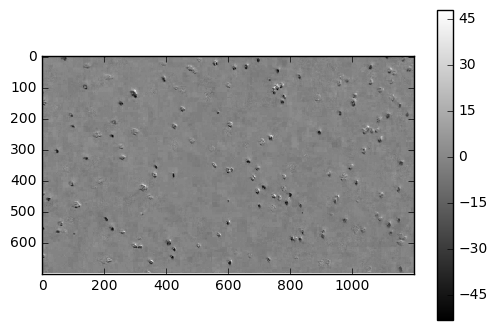

In [12]:
plt.figure()

plt.imshow(moving[100] )
plt.colorbar()

We now need to reduce noise within the image. We can do this by applying a Gaussian filter that will blur the image and subdue noisy pixels. The numbers in brackets are the sigma values for the filter specified for two dimensions only. This ensures the filter is only applied to the X and Y dimensions and not to the time dimension.

In [13]:
# Create a filtered version of the array

frames_filter = np.array( [ nd.filters.gaussian_filter(frame, [2, 2] ) for frame in moving] )
moving = 0

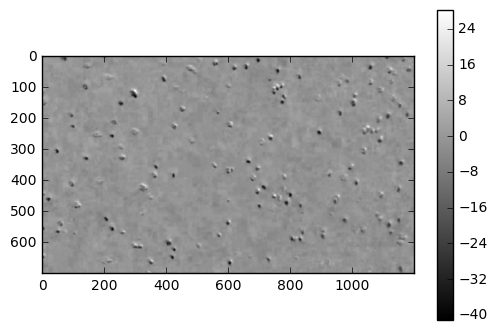

In [14]:
plt.figure()

plt.imshow( frames_filter[100] )
plt.colorbar()

## IMPORTANT
Your data will need careful thresholding to remove background. In the code below, the variable 'thresh' is '130'. This means that any feature brighter than 130 will be discarded. You may need to alter this value for your own images, depending on the brightness of the background. We also invert the immage so that the black dots become white dots, which makes downstream processing more intuitive (i.e. higher pixel values mean a higher chance those pixels are part of an object).

In [15]:
# The command below makes a binary image from the inverted original image. The threshold is set manually here.
# By using the threshold we remove any lighter noise that can confuse the tracking.
# For later analysis, we need to convert the type of this array to 'uint8' 

#thresh = -5

#frames_inv = np.array( [ (frame > thresh)*255 for frame in frames_filter] ).astype('uint8')

In [16]:
# Check one of these binary frames
#print(frames_filter[100].max())
#plt.figure()

#plt.imshow( frames_inv[100] )
#plt.colorbar()

In [17]:
#plt.imshow( 255-frames_inv[100] )
#plt.colorbar()

In [18]:
#frames_inv2 = 255 - frames_inv

In [19]:
val = -20 #filters.threshold_otsu(frames_filter) # Otsu method of thresholding

invertval = frames_filter < val
frames_filter = 0

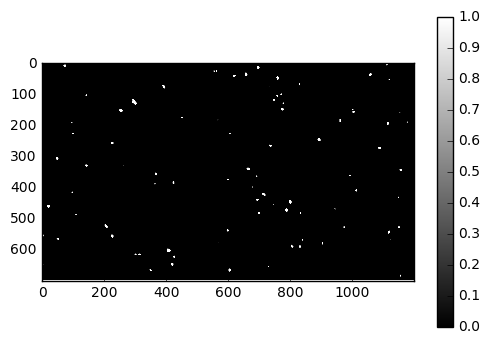

In [20]:
plt.imshow(invertval[100])#, cmap='gray')#, interpolation='nearest')

plt.colorbar()

In [21]:
#import imageio
#kargs = {'macro_block_size': None}
#imageio.mimsave(r'c:\Users\swn202\Documents\test_int.mp4', 
#                invertval[:100].astype(np.uint8),'MP4',**kargs)

In [22]:
#?imageio.mimsave


## TrackPy
This section of the script utilises TrackPy. We will use it to locate the cells and to track the movement of each cell over time. From this we will be able to determine track length of the cells.

In [23]:
# The function below searches the image for objects of 21 pixels in diameter.
# It returns a pandas dataframe of information about all objects it finds.
# It is looking for bright spots in the image, which is one reason for inverting the images above.

cell = tp.locate( invertval[100], 21, invert = False )

In [24]:
#?tp.locate

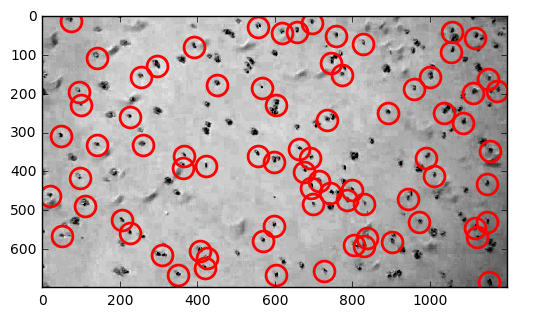

In [25]:
# The results can be plotted on top of the original image.

plt.figure()

tp.annotate(cell, frames_crop100)

In [26]:
# The function below executes the same search on all frames.
# Note: if there are many features/frames, this can take a while to execute.
# The minmass kwarg is a threshold for the 'bright' points. In our case, values are either 255 or 0
# so any number in between is fine.
# Above two statements are not necessarily true as the data type is now a float - for Apex_test1, Otsus, it is 0 or 1
# You might want to limit the range to the first 100 frames to start with to see what is happening.

cells = tp.batch( invertval, 21, minmass = 0.8, invert = False )

Frame 359: 77 features


In [27]:
# The features (cell positions) can now be linked.
# The number '10' is the maximum 'step' in pixels allowed between frames so
#     for fast moving chlamy this should be increased, keep consistent.
#     It is the search range
# Memory is the number of frames a chlamy can disappear for

tracks = tp.link_df( cells, 50, memory = 3 )

Frame 359: 77 trajectories present


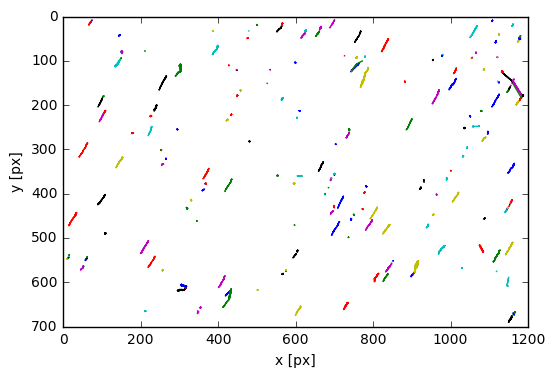

In [28]:
plt.figure()
tp.plot_traj(tracks);

In [29]:
#?tp.link_df

In [30]:
#Just for visualisation
# To measure 'genuine' tracks (as opposed to noise) we should remove short tracks
# We shall use a cut-off of 50.
# This is the number of frames that it must be tracked. For 100 frames this is too high

tracks_long = tp.filter_stubs( tracks, 50 )

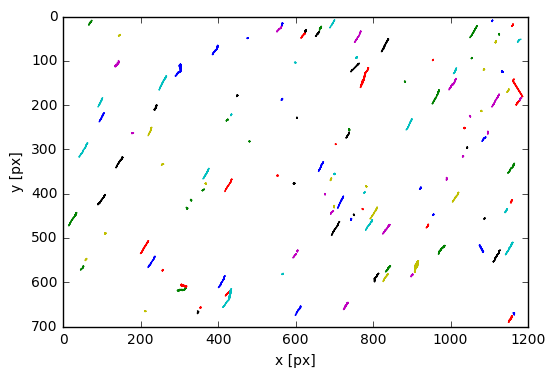

In [31]:
# The moment of truth! The tracks can now be plotted.

plt.figure()

tp.plot_traj( tracks_long );

## Track length
Plot histogram 
Try for before and after the background subtraction to see if there is a difference - should remove really long tracks
Find average
Convert to microns to standardise between each microscope


In [32]:
f = cells

In [33]:
# Conversion of pixels to micrometres using conversion data already calculated
# 0.0936 Primo
# 0.0945 Apex
# 0.0880 My 1st

f['xum'] = f['x'] * 0.0880
f['yum'] = f['y'] * 0.0880

In [34]:
# Tracks in micrometres instead of frames
linked = tp.link_df( f, 50, memory = 3 )
tracks = 0

Frame 359: 77 trajectories present


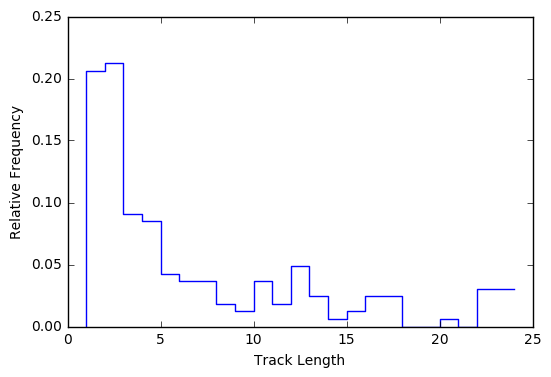

In [35]:
# normed = True makes it realtive frequency
#linked = tracks #tp.link_df(f, 6)

hist, bins = np.histogram(np.bincount(linked.particle.astype(int)), bins=np.arange(0,25), normed=True)
plt.step(bins[1:], hist)
plt.xlabel('Track Length')
plt.ylabel('Relative Frequency')
plt.show()

In [36]:
hist

array([ 0.        ,  0.20606061,  0.21212121,  0.09090909,  0.08484848,
        0.04242424,  0.03636364,  0.03636364,  0.01818182,  0.01212121,
        0.03636364,  0.01818182,  0.04848485,  0.02424242,  0.00606061,
        0.01212121,  0.02424242,  0.02424242,  0.        ,  0.        ,
        0.00606061,  0.        ,  0.03030303,  0.03030303])

In [37]:
hist1, bins1 = np.histogram(np.bincount(linked.particle.astype(int)), bins=np.arange(0,25))
hist1

array([ 0, 34, 35, 15, 14,  7,  6,  6,  3,  2,  6,  3,  8,  4,  1,  2,  4,
        4,  0,  0,  1,  0,  5,  5])

In [38]:
hist2 = np.delete(hist1, [0], None)
hist2

array([34, 35, 15, 14,  7,  6,  6,  3,  2,  6,  3,  8,  4,  1,  2,  4,  4,
        0,  0,  1,  0,  5,  5])

In [39]:
#np.savetxt('freq.csv', hist2, delimiter=',')

In [40]:
total_freq = 0
for i in hist2:
    total_freq += i
total_freq

165

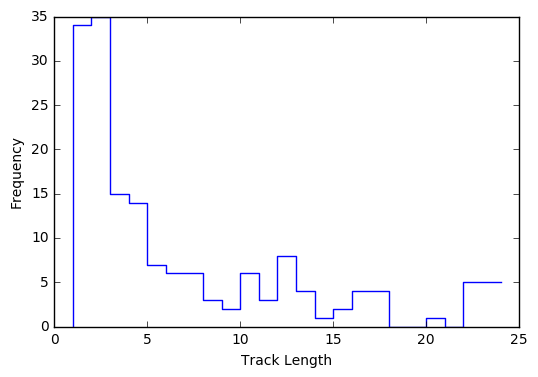

In [41]:
#hist1, bins1 = np.histogram(np.bincount(linked.particle.astype(int)), bins=np.arange(0,25))
plt.step(bins1[1:], hist1)
plt.xlabel('Track Length')
plt.ylabel('Frequency')
plt.show()

In [42]:
bins2 = np.linspace(0.5,23.5,num = 47)
bins2

array([  0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,   4.5,
         5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,
         9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,  13.5,
        14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,
        18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,  22.5,
        23. ,  23.5])

In [43]:
mid_bins = bins2[::2]
mid_bins

array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5])

In [44]:
x_y0 = hist1*mid_bins
x_y0

array([   0. ,   51. ,   87.5,   52.5,   63. ,   38.5,   39. ,   45. ,
         25.5,   19. ,   63. ,   34.5,  100. ,   54. ,   14.5,   31. ,
         66. ,   70. ,    0. ,    0. ,   20.5,    0. ,  112.5,  117.5])

In [45]:
x_y = np.delete(x_y0, [0], None)

In [46]:
#np.savetxt('freq_times_bin.csv', x_y, delimiter=',')

In [47]:
len(x_y)

23

In [48]:
np.sort(x_y)

array([   0. ,    0. ,    0. ,   14.5,   19. ,   20.5,   25.5,   31. ,
         34.5,   38.5,   39. ,   45. ,   51. ,   52.5,   54. ,   63. ,
         63. ,   66. ,   70. ,   87.5,  100. ,  112.5,  117.5])

In [49]:
x_yt = 0
for n in x_y:
    x_yt += n
x_yt

1104.5

In [50]:
mean_len = (x_yt)/total_freq
mean_len

6.6939393939393943

In [51]:
cum_freq = hist1.cumsum()
cum_freq

array([  0,  34,  69,  84,  98, 105, 111, 117, 120, 122, 128, 131, 139,
       143, 144, 146, 150, 154, 154, 154, 155, 155, 160, 165])

In [52]:
prop_greater_that_prev = 1 - cum_freq / cum_freq[-1]
prop_greater_that_prev

array([ 1.        ,  0.79393939,  0.58181818,  0.49090909,  0.40606061,
        0.36363636,  0.32727273,  0.29090909,  0.27272727,  0.26060606,
        0.22424242,  0.20606061,  0.15757576,  0.13333333,  0.12727273,
        0.11515152,  0.09090909,  0.06666667,  0.06666667,  0.06666667,
        0.06060606,  0.06060606,  0.03030303,  0.        ])

In [53]:
bins3 = np.delete(bins1, [24], None)
bins3

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [54]:
np.shape(prop_greater_that_prev)

(24,)

In [55]:
np.shape(bins3)

(24,)

#### Median in value found between the proportions ??? and ???
#### This falls between bin ? and ? 
#### NB counting from 0,1,2,3,4,...

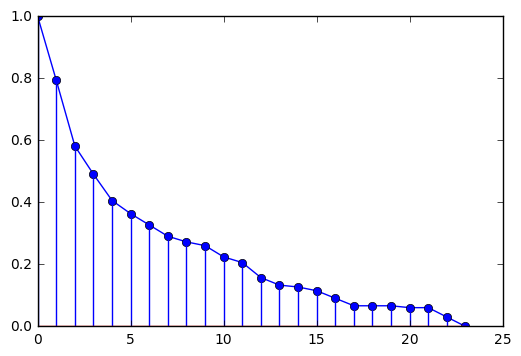

In [56]:
plt.figure()
plt.plot(bins3,prop_greater_that_prev)
plt.stem(bins3,prop_greater_that_prev)
plt.show()

In [57]:
np.savetxt('/Users/Stan/Desktop/Uni/Frontiers/Project (microscopes)/Medians/median_immotile_primo_w3.csv', prop_greater_that_prev, delimiter=',')

In [58]:
mean_length = ([mean_len])
mean_length

[6.6939393939393943]

In [59]:
np.savetxt('/Users/Stan/Desktop/Uni/Frontiers/Project (microscopes)/Means/mean_immotile_primo_w3.csv', mean_length, delimiter=',')